In [106]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import json
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error

## Import Pixels Data

In [107]:
# Import pixels data
pixels_filename = './dataset/pixels/Pixels backup_ 2022-02-07 18_28_02.258.json'
with open(pixels_filename, 'r') as file:
    pixels_objects = json.loads(file.read())

# Change extreme values closer to neutral and shift values by -1
def parse_pixel_obj(object):
    value = object['entries'][0]['value']
    if value == 1:
        value = 2
    elif value == 5:
        value = 4
    return {
        'date': object['date'],
        'mood': value-1
    }

parsed_pixel_objs = [ parse_pixel_obj(object) for object in pixels_objects ]

pixels_mood_df = pd.DataFrame(parsed_pixel_objs)
pixels_mood_df

,date,mood
0,2020-01-24,3
1,2020-01-25,3
2,2020-01-26,3
3,2020-01-27,3
4,2020-01-28,2
...,...,...
740,2022-02-02,3
741,2022-02-03,3
742,2022-02-04,3
743,2022-02-05,2


## Import Fitbit Data

In [108]:
# Import fitbit data

## Sleep
sleep_dir = './dataset/fitbit/Sleep'
sleep_json_files = list(filter(lambda filename: filename.startswith('sleep-'), os.listdir(sleep_dir)))

def load_sleep_json(filename):
    with open(os.path.join(sleep_dir, filename), 'r') as file:
        file_sleep_objs = json.loads(file.read())

    return file_sleep_objs

sleep_objects = []
for file in sleep_json_files:
    sleep_objects += load_sleep_json(file)


# Filter sleeps
sleep_obj_filter_lambda = lambda obj: obj['mainSleep'] and obj['levels'] and obj['type'] != 'classic'
sleep_objects = list(filter(sleep_obj_filter_lambda, sleep_objects))

def parse_sleep_object(obj):
    return {
        'date': obj['dateOfSleep'],
        'wake_minutes': obj['levels']['summary']['wake']['minutes'],
        'light_minutes': obj['levels']['summary']['light']['minutes'],
        'rem_minutes': obj['levels']['summary']['rem']['minutes'],
        'deep_minutes': obj['levels']['summary']['deep']['minutes'],
        'total_sleep_minutes': obj['levels']['summary']['light']['minutes'] + obj['levels']['summary']['rem']['minutes'] + obj['levels']['summary']['deep']['minutes'],
    }

parsed_sleep_objects = [ parse_sleep_object(obj) for obj in sleep_objects ]
sleep_df = pd.DataFrame(parsed_sleep_objects)

sleep_df

,date,wake_minutes,light_minutes,rem_minutes,deep_minutes,total_sleep_minutes
0,2018-03-03,55,245,80,132,457
1,2018-03-02,57,192,68,68,328
2,2018-03-01,47,195,58,91,344
3,2018-02-28,57,257,22,85,364
4,2018-02-27,41,174,54,64,292
...,...,...,...,...,...,...
1158,2022-02-06,67,261,83,113,457
1159,2022-02-05,45,215,75,93,383
1160,2022-02-04,82,255,53,125,433
1161,2022-02-03,68,245,85,100,430


In [109]:
## Resting heart rate

physical_activity_dir = './dataset/fitbit/Physical Activity'
hr_files = list(filter(lambda filename: filename.startswith('resting_heart_rate'), os.listdir(physical_activity_dir)))

hr_objects = []

for filename in hr_files:
    with open(os.path.join(physical_activity_dir, filename), 'r') as file:
        hr_objects += json.loads(file.read())

# Filter null heartrate objects
hr_objects = list(filter(lambda obj: obj['value']['date'], hr_objects))

def parse_hr_obj(obj):
    us_date = obj['value']['date']
    date = f"20{us_date[-2:]}-{us_date[:2]}-{us_date[3:5]}"
    return {
        'date': date,
        'resting_heartrate': obj['value']['value']
    }

parsed_hr_objects = [ parse_hr_obj(obj) for obj in hr_objects ]
hr_df = pd.DataFrame(parsed_hr_objects)
hr_df

,date,resting_heartrate
0,2018-02-24,64.000000
1,2018-02-25,63.392424
2,2018-02-26,60.323800
3,2018-02-27,61.019566
4,2018-02-28,61.809670
...,...,...
1144,2022-02-03,60.820997
1145,2022-02-04,59.765384
1146,2022-02-05,58.289222
1147,2022-02-06,58.807329


## Preprocess Data

In [110]:
# Merge dataframes on date
mood_hr_df = pd.merge(pixels_mood_df, hr_df, on="date", how="inner")
whole_df = pd.merge(mood_hr_df, sleep_df, on="date", how="inner")
whole_df

,date,mood,resting_heartrate,wake_minutes,light_minutes,rem_minutes,deep_minutes,total_sleep_minutes
0,2020-01-24,3,62.092401,65,290,66,49,405
1,2020-01-25,3,61.894955,76,287,57,103,447
2,2020-01-26,3,62.947462,64,294,40,74,408
3,2020-01-27,3,63.737734,43,260,60,57,377
4,2020-01-29,2,63.114227,50,224,36,71,331
...,...,...,...,...,...,...,...,...
760,2022-02-02,3,60.718213,91,307,59,116,482
761,2022-02-03,3,60.820997,68,245,85,100,430
762,2022-02-04,3,59.765384,82,255,53,125,433
763,2022-02-05,2,58.289222,45,215,75,93,383


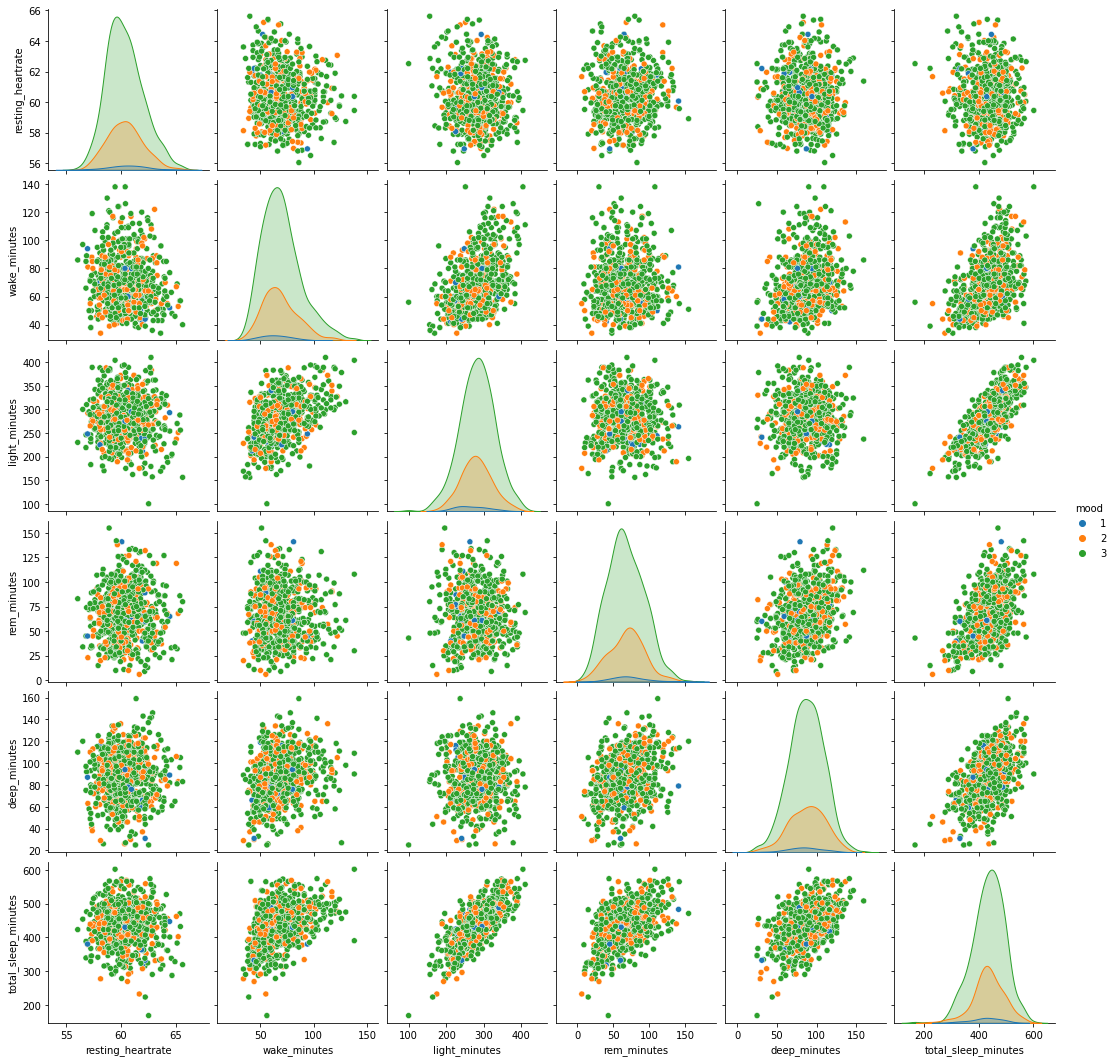

In [111]:
# Plot the data
sns.pairplot(whole_df,hue = 'mood',diag_kind = "kde", kind = "scatter", palette = "tab10")
plt.show()

## Formatting data for training

In [112]:
# Convert to numpy
y = whole_df['mood'].to_numpy()
X = whole_df.drop(columns=['date', 'mood']).to_numpy()

# Split to training, validation and test sets
X_train, X_rem, y_train, y_rem = train_test_split(X, y, test_size=0.4, random_state=1)
X_val, X_test, y_val, y_test = train_test_split(X_rem, y_rem, test_size=0.2, random_state=1)

y_val_temp = list(y_val)
y_val_class_dist = [y_val_temp.count(1)/len(y_val_temp), y_val_temp.count(2)/len(y_val_temp), y_val_temp.count(3)/len(y_val_temp)]

print(X_train.shape, X_val.shape, X_test.shape)
print(y_train.shape, y_val.shape, y_test.shape)
print(y_val_class_dist)

(459, 6) (244, 6) (62, 6)
(459,) (244,) (62,)
[0.020491803278688523, 0.26229508196721313, 0.7172131147540983]


## Training the Model

deg: 1 min: 2.483196046218699 max: 2.908542284908086
deg: 2 min: 2.371685165182817 max: 3.1920281299801783
deg: 3 min: 2.020981944317043 max: 3.8566438172703954
deg: 4 min: -2.7511825561523438 max: 3.776970863342285


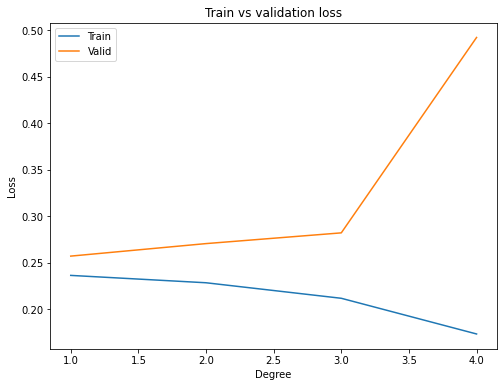

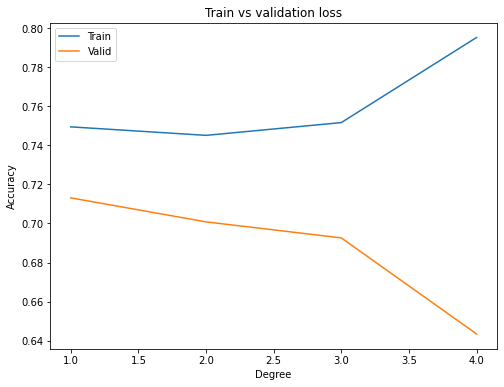

[0.7494553376906318, 0.7450980392156863, 0.7516339869281046, 0.7952069716775599]
[0.7131147540983607, 0.7008196721311475, 0.6926229508196722, 0.6434426229508197]


In [113]:
from sklearn.preprocessing import PolynomialFeatures


degrees = list(range(1,5))
tr_errors = []
val_errors = []
tr_accs = []
val_accs = []
regressors = []
poly_features = []

def prediction_to_class(pred):
    if pred < 1.5:
        return 1
    elif pred < 2.5:
        return 2
    else:
        return 3

for degree in degrees:
    lin_regr = LinearRegression(fit_intercept=False)
    regressors.append(lin_regr)
    poly = PolynomialFeatures(degree=degree)
    poly_features.append(poly)

    X_train_poly = poly.fit_transform(X_train)
    lin_regr.fit(X_train_poly, y_train)

    y_pred_train = lin_regr.predict(X_train_poly)
    y_pred_class_train = list(map(prediction_to_class, y_pred_train))
    tr_error = mean_squared_error(y_train,y_pred_train)
    tr_acc = accuracy_score(y_train, y_pred_class_train)
    tr_accs.append(tr_acc)
    tr_errors.append(tr_error)


    X_val_poly = poly.fit_transform(X_val)
    y_pred_val = lin_regr.predict(X_val_poly)
    y_pred_class_val = list(map(prediction_to_class, y_pred_val))
    val_acc = accuracy_score(y_val, y_pred_class_val)
    val_accs.append(val_acc)
    val_error = mean_squared_error(y_val,y_pred_val)
    val_errors.append(val_error)

    print(f"deg: {degree} min: {min(y_pred_val)} max: {max(y_pred_val)}")
    # print(f"deg: {degree} min: {min(y_pred_train)} max: {max(y_pred_train)}")

# Error
plt.figure(figsize=(8, 6))

plt.plot(degrees, tr_errors, label = 'Train')
plt.plot(degrees, val_errors,label = 'Valid')
plt.legend(loc = 'upper left')

plt.xlabel('Degree')
plt.ylabel('Loss')
plt.title('Train vs validation loss')
plt.show()

# Accuracy
plt.figure(figsize=(8, 6))

plt.plot(degrees, tr_accs, label = 'Train')
plt.plot(degrees, val_accs,label = 'Valid')
plt.legend(loc = 'upper left')

plt.xlabel('Degree')
plt.ylabel('Accuracy')
plt.title('Train vs validation loss')
plt.show()

print(tr_accs)
print(val_accs)



chosen_polynomial = poly_features[val_accs.index(max(val_accs))]
chosen_regressor = regressors[val_accs.index(max(val_accs))]

In [114]:
## Failed attempt of trying logicstic regression for prediction
# C is inverse of regularization strength
c = 10000000000000000
classifier = LogisticRegression(C=c, max_iter=1000, multi_class='ovr')

classifier.fit(X_train, y_train)

y_pred_train = classifier.predict(X_train)
acc_train = accuracy_score(y_train, y_pred_train)

y_pred_val = classifier.predict(X_val)
acc_val = accuracy_score(y_val, y_pred_val)

print("Training accuracy:", acc_train)
print("Validation accuracy:", acc_val)
# print(y_pred_train)
# print(y_pred_val)

Training accuracy: 0.7516339869281046
Validation accuracy: 0.7172131147540983


In [115]:
from sklearn.neural_network import MLPClassifier

In [116]:
## Note: the execution time of this cell might be > 2 mins
## define a list of values for the number of hidden layers
num_layers_clf = [1,2,4,6,8,10]    # number of hidden layers,
num_neurons = 20


# we will use this variables to store the resulting training accs for each number of hidden layers
mlp_tr_accs = []
mlp_val_accs = []

mlp_classifiers = []

for i,num in enumerate(num_layers_clf):
    hidden_layer_sizes = tuple([num_neurons]*num)

    mlp_clf = MLPClassifier(
        hidden_layer_sizes=hidden_layer_sizes,
        max_iter=5000,
        learning_rate_init=0.0001,
        random_state=0
    )
    mlp_classifiers.append(mlp_clf)
    mlp_clf.fit(X_train, y_train)
    
    
    y_pred_train = mlp_clf.predict(X_train)    # predict using the trained model
    # y_pred_train_prob = mlp_clf.predict_proba(X_train)    # predict using the trained model
    tr_acc = accuracy_score(y_train, y_pred_train)    # calculate the training acc

    # print(y_pred_train_prob)

    y_pred_val = mlp_clf.predict(X_val) # predict for the validation data 
    val_acc =  accuracy_score(y_val, y_pred_val) # calculate the validation acc
    # print(y_pred_val)
    
    mlp_tr_accs.append(tr_acc)
    mlp_val_accs.append(val_acc)

print(mlp_tr_accs)
print(mlp_val_accs)

chosen_mlp_classifier = mlp_classifiers[list(mlp_val_accs).index(max(mlp_val_accs))]



[0.22657952069716775, 0.02178649237472767, 0.7516339869281046, 0.7516339869281046, 0.7494553376906318, 0.7516339869281046]
[0.26229508196721313, 0.020491803278688523, 0.7172131147540983, 0.7090163934426229, 0.7172131147540983, 0.7172131147540983]


# Test accuracy

In [119]:
# polynomial
X_test_poly = chosen_polynomial.fit_transform(X_test)
y_pred_test = chosen_regressor.predict(X_test_poly)
y_pred_class_val = list(map(prediction_to_class, y_pred_test))
poly_test_acc = accuracy_score(y_test, y_pred_class_val)
print("Polynomial test accuracy: " + str(poly_test_acc))

# multi-layer preceptor
y_pred_test_mlp = chosen_mlp_classifier.predict(X_test)
mlp_test_acc = accuracy_score(y_test, y_pred_test_mlp)
print("Multilayer perceptor accuracy: " + str(mlp_test_acc))

Polynomial test accuracy: 0.7258064516129032
Multilayer perceptor accuracy: 0.7258064516129032
